<a href="https://colab.research.google.com/github/NajlaZuhir/Financial-Distress-Prediction/blob/main/Notebook_Company_Distress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Financially Distressed Companies: Addressing Class Imbalance**

This project aims to identify financially distressed companies; those struggling to pay employees, meet bill payments, or fulfil other financial obligations. Early detection is critical, as the cost of missing a distressed firm far outweighs the cost of falsely flagging a healthy one. This asymmetry makes the problem inherently cost-sensitive, shifting the focus toward minimizing false negatives (catching as many distressed cases) and driving the need to explicitly address the class imbalance present in the data.



#### 1) **Data Understanding & Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [ ]:
df = pd.read_csv('Financial Distress.csv')

# Binarise target: 1 = Financially Distressed, 0 = Healthy
df['Financial Distress'] = (df['Financial Distress'] < -0.5).astype(int)

print(f'Dataset shape : {df.shape}')
print(f'Companies     : {df.Company.nunique()}')
print(f'Missing values: {df.isnull().sum().sum()}')
df.head()

Dataset shape : (3672, 86)
Companies     : 422
Missing values: 0


,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print(f"Number of numerical variables: {len(numerical_cols)}")
print(f"Number of categorical variables: {len(categorical_cols)}")


Number of numerical variables: 86
Number of categorical variables: 0


Financial Distress
0    3536
1     136
Name: count, dtype: int64

Imbalance ratio: 26.0:1  (majority:minority)


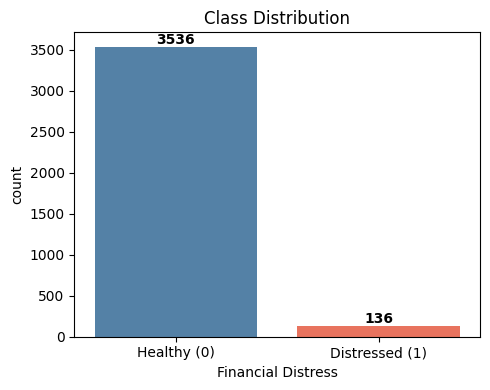

In [ ]:
# Class distribution
counts = df['Financial Distress'].value_counts()
print(counts)
print(f'\nImbalance ratio: {counts[0]/counts[1]:.1f}:1  (majority:minority)')

fig, ax = plt.subplots(figsize=(5, 4))
sns.countplot(x='Financial Distress', data=df, ax=ax,
              palette=['steelblue', 'tomato'])
ax.set_xticklabels(['Healthy (0)', 'Distressed (1)'])
ax.set_title('Class Distribution')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

**Summary:**
- Dataset shape: (3672, 86).
- All columns are numerical with no missing values.
- The dataset is highly dimensional & imbalanced; with Class 0 (Healthy) >> Class 1 (Distressed).


#### 2) **Modelling & Evaluation**

##### 2.1 · Data Split
rain/Validation/Test split (70 / 15 / 15) — stratified to preserve the minority class ratio.

In [ ]:
X = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']

# 70 / 30 first split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)

# 15 / 15 second split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)

print(f'Train : {X_train.shape}  minority={y_train.sum()}')
print(f'Val   : {X_val.shape}   minority={y_val.sum()}')
print(f'Test  : {X_test.shape}  minority={y_test.sum()}')

Train : (2570, 85)  minority=95
Val   : (551, 85)   minority=21
Test  : (551, 85)  minority=20


##### 2.2 · Helper Utilities
Centralised evaluation and plotting functions — used throughout the notebook.

In [ ]:
def evaluate_model(name, model, X_tr, y_tr, X_ev, y_ev,
                   sampler=None, sampler_name='None'):
    """Fit model (optionally with sampler) and return metrics dict."""
    if sampler is not None:
        X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_ev)
    return {
        'Model'        : name,
        'Sampling'     : sampler_name,
        'Recall'       : round(recall_score(y_ev, y_pred, pos_label=1), 4),
        'F1'           : round(f1_score(y_ev, y_pred, pos_label=1), 4),
        '_y_pred'      : y_pred,   # keep for confusion matrix
    }


def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Healthy', 'Distressed'],
                yticklabels=['Healthy', 'Distressed'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_class_distribution(y_resampled, title='After Resampling'):
    counts = pd.Series(y_resampled).value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.bar(counts.index, counts.values, color=['steelblue', 'tomato'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Healthy (0)', 'Distressed (1)'])
    ax.set_ylabel('Count')
    ax.set_title(title)
    for i, v in zip(counts.index, counts.values):
        ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()


# Model factory — fresh instance each call
def get_models():
    return [
        ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ('Random Forest',       RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
        ('XGBoost',             XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE)),
    ]

print('Utilities ready ✔')

Utilities ready ✔


##### 2.3 · Modelling - Baseline Results
Training on the raw imbalanced data as a reference point

Logistic Regression        Recall=0.0476  F1=0.0870


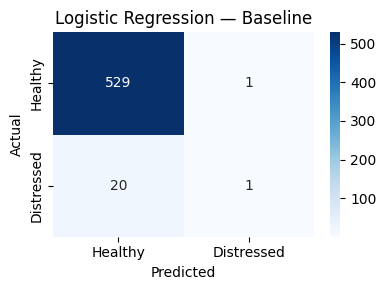

Random Forest              Recall=0.1905  F1=0.3077


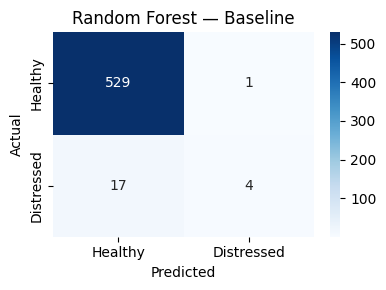

XGBoost                    Recall=0.1429  F1=0.1935


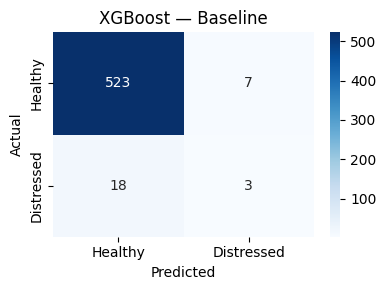

In [ ]:
baseline_results = []
for name, model in get_models():
    r = evaluate_model(name, model, X_train, y_train, X_val, y_val,
                       sampler=None, sampler_name='None (Baseline)')
    baseline_results.append(r)
    print(f'{name:25s}  Recall={r["Recall"]:.4f}  F1={r["F1"]:.4f}')
    plot_confusion_matrix(y_val, r['_y_pred'], title=f'{name} — Baseline')

all_results = baseline_results.copy()

#### 3) **Sampling Techniques**

**Note:** Sampling is applied only to the training set. The validation and test sets are never touched as they must reflect the real-world distribution.

##### 3.1 · Random Over-Sampling
Duplicates minority samples at random

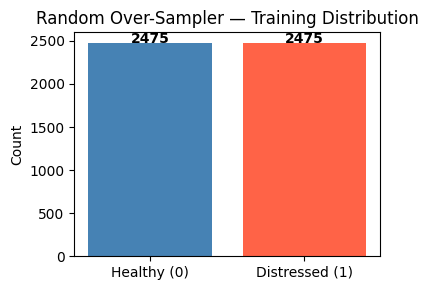

In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
plot_class_distribution(y_ros, 'Random Over-Sampler — Training Distribution')

Logistic Regression        Recall=0.7143  F1=0.1754


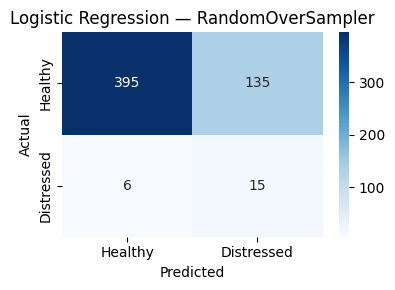

Random Forest              Recall=0.2857  F1=0.3429


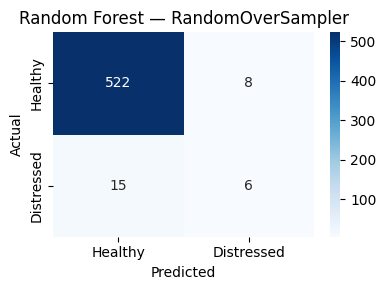

XGBoost                    Recall=0.2381  F1=0.2381


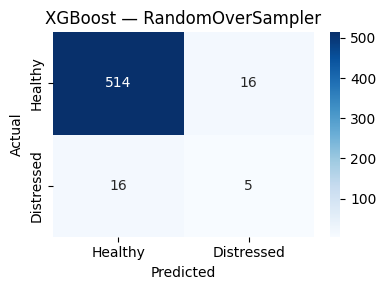

In [ ]:
ros_results = []
for name, model in get_models():
    r = evaluate_model(name, model, X_train, y_train, X_val, y_val,
                       sampler=RandomOverSampler(random_state=RANDOM_STATE),
                       sampler_name='RandomOverSampler')
    ros_results.append(r)
    print(f'{name:25s}  Recall={r["Recall"]:.4f}  F1={r["F1"]:.4f}')
    plot_confusion_matrix(y_val, r['_y_pred'], title=f'{name} — RandomOverSampler')

all_results.extend(ros_results)

##### 3.2 · SMOTE (Synthetic Minority Over-sampling Technique)
Synthesises new minority samples between neighbours

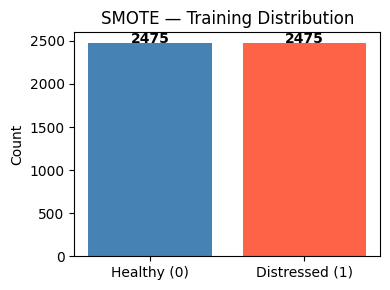

In [ ]:
smote = SMOTE(random_state=RANDOM_STATE)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
plot_class_distribution(y_smote, 'SMOTE — Training Distribution')

Logistic Regression        Recall=0.7143  F1=0.1887


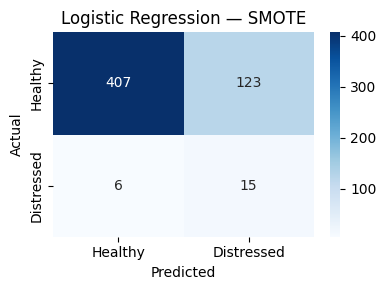

Random Forest              Recall=0.4286  F1=0.3529


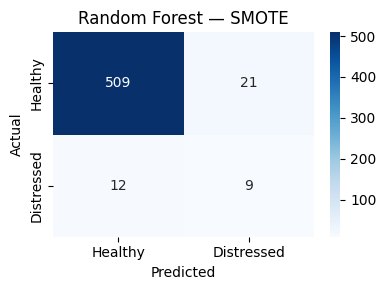

XGBoost                    Recall=0.2381  F1=0.1961


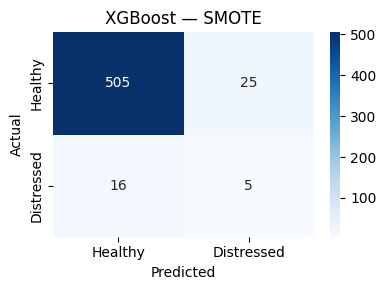

In [ ]:
smote_results = []
for name, model in get_models():
    r = evaluate_model(name, model, X_train, y_train, X_val, y_val,
                       sampler=SMOTE(random_state=RANDOM_STATE),
                       sampler_name='SMOTE')
    smote_results.append(r)
    print(f'{name:25s}  Recall={r["Recall"]:.4f}  F1={r["F1"]:.4f}')
    plot_confusion_matrix(y_val, r['_y_pred'], title=f'{name} — SMOTE')

all_results.extend(smote_results)

##### 3.3 · Random Under-Sampling
Randomly removes majority samples

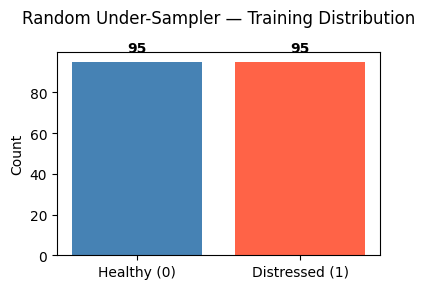

In [ ]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
plot_class_distribution(y_rus, 'Random Under-Sampler — Training Distribution\n')

Logistic Regression        Recall=0.7143  F1=0.1523


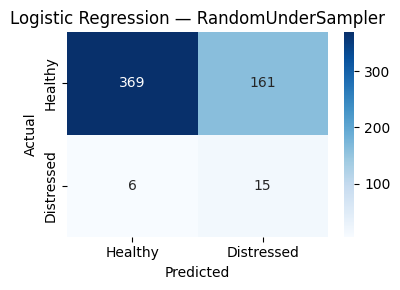

Random Forest              Recall=0.8571  F1=0.2812


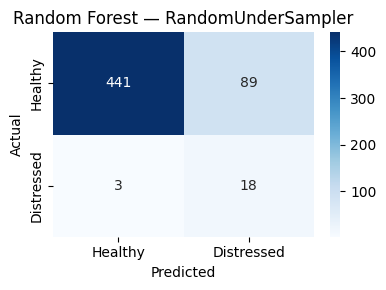

XGBoost                    Recall=0.8095  F1=0.2500


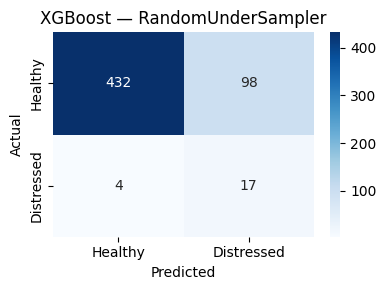

In [ ]:
rus_results = []
for name, model in get_models():
    r = evaluate_model(name, model, X_train, y_train, X_val, y_val,
                       sampler=RandomUnderSampler(random_state=RANDOM_STATE),
                       sampler_name='RandomUnderSampler')
    rus_results.append(r)
    print(f'{name:25s}  Recall={r["Recall"]:.4f}  F1={r["F1"]:.4f}')
    plot_confusion_matrix(y_val, r['_y_pred'], title=f'{name} — RandomUnderSampler')

all_results.extend(rus_results)

#### 4) **Full Comparison**

In [ ]:
# Build master results table (drop internal _y_pred)
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != '_y_pred'}
    for r in all_results
])

results_df = results_df.sort_values('Recall', ascending=False).reset_index(drop=True)
results_df

,Model,Sampling,Recall,F1
0,Random Forest,RandomUnderSampler,0.8571,0.2812
1,XGBoost,RandomUnderSampler,0.8095,0.2500
2,Logistic Regression,RandomOverSampler,0.7143,0.1754
3,Logistic Regression,SMOTE,0.7143,0.1887
4,Logistic Regression,RandomUnderSampler,0.7143,0.1523
5,Random Forest,SMOTE,0.4286,0.3529
6,Random Forest,RandomOverSampler,0.2857,0.3429
7,XGBoost,RandomOverSampler,0.2381,0.2381
8,XGBoost,SMOTE,0.2381,0.1961
9,Random Forest,None (Baseline),0.1905,0.3077


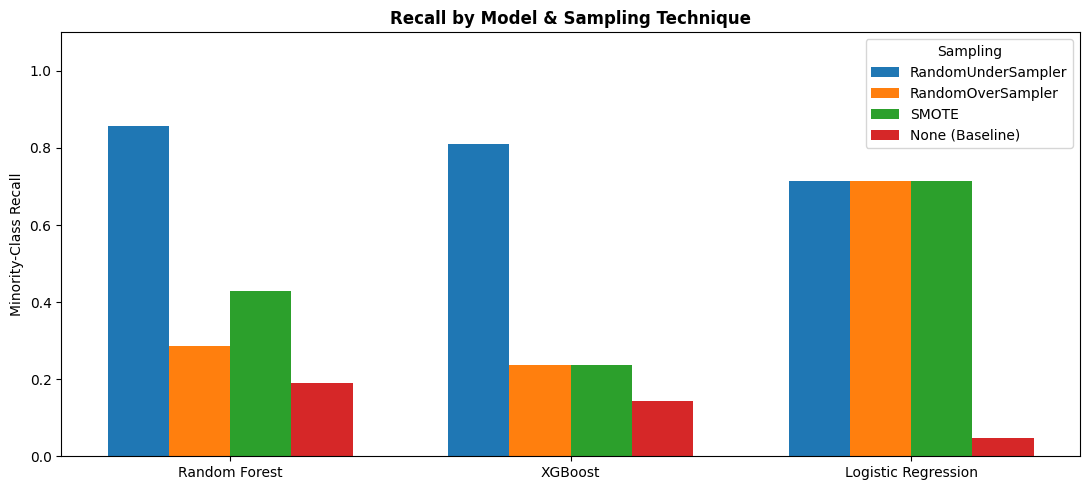

In [ ]:
# Bar chart — Recall comparison grouped by model
fig, ax = plt.subplots(figsize=(11, 5))
x = np.arange(len(results_df['Model'].unique()))
samplers  = results_df['Sampling'].unique()
width = 0.18

for i, samp in enumerate(samplers):
    subset = results_df[results_df['Sampling'] == samp].set_index('Model')
    models_order = results_df['Model'].unique()
    vals = [subset.loc[m, 'Recall'] if m in subset.index else 0 for m in models_order]
    ax.bar(x + i * width, vals, width, label=samp)

ax.set_xticks(x + width * (len(samplers) - 1) / 2)
ax.set_xticklabels(models_order)
ax.set_ylabel('Minority-Class Recall')
ax.set_title('Recall by Model & Sampling Technique', fontweight='bold')
ax.legend(title='Sampling', bbox_to_anchor=(1, 1))
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

**Summary:**

- Due to severe class imbalance, correctly identifying financially distressed companies is far more critical than mistakenly flagging healthy ones;  undetected distress can lead to unpaid employees, missed payments, and financial collapse.

- To address the imbalance, three sampling techniques (RandomOverSampler, SMOTE, and RandomUnderSampler) were applied across all three models and compared using minority-class Recall and F1 as primary metrics.

**Selected Models:** Random Forest and XGBoost with RandomUnderSampler stood out as the strongest performers.
